# Transfer Learning with Tensorflow: Feature Extraction

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import os
from tensorflow.keras import Sequential
from tensorflow.keras import layers
import tensorflow_hub as hub

In [2]:
!nvidia-smi

Mon Aug 16 18:29:41 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
def plot_history(model_history):
  """
  Helper function to automate plotting a tf history object
  """
  df = pd.DataFrame(model_history.history)

  plt.figure(figsize=(12, 6))
  plt.subplot(1,2,1)
  df.loss.plot(label="training loss")
  df.val_loss.plot(label="testing loss")
  plt.ylabel("LOSS")
  plt.xlabel("EPOCHS")
  plt.legend()

  plt.subplot(1,2,2)
  df.accuracy.plot(label="training acc")
  df.val_accuracy.plot(label="testing acc")
  plt.ylabel("ACCURACY")
  plt.xlabel("EPOCHS")
  plt.legend()
  plt.tight_layout()
  return plt.show()

In [4]:
# import 10% of 10 food classes from Food101 used in previous dataset
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2021-08-16 18:29:42--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 74.125.197.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   201MB/s    in 0.8s    

2021-08-16 18:29:43 (201 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} dirs and {len(filenames)} files in '{dirpath}'.")

There are 2 dirs and 0 files in '10_food_classes_10_percent'.
There are 10 dirs and 0 files in '10_food_classes_10_percent/train'.
There are 0 dirs and 75 files in '10_food_classes_10_percent/train/steak'.
There are 0 dirs and 75 files in '10_food_classes_10_percent/train/ramen'.
There are 0 dirs and 75 files in '10_food_classes_10_percent/train/fried_rice'.
There are 0 dirs and 75 files in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 dirs and 75 files in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 dirs and 75 files in '10_food_classes_10_percent/train/pizza'.
There are 0 dirs and 75 files in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 dirs and 75 files in '10_food_classes_10_percent/train/hamburger'.
There are 0 dirs and 75 files in '10_food_classes_10_percent/train/ice_cream'.
There are 0 dirs and 75 files in '10_food_classes_10_percent/train/sushi'.
There are 10 dirs and 0 files in '10_food_classes_10_percent/test'.
There are 0 d

## Prep data using data loaders

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir="10_food_classes_10_percent/train/"
test_dir="10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_perc = train_datagen.flow_from_directory(train_dir, 
                                                       target_size=IMG_SHAPE,
                                                       batch_size=BATCH_SIZE,
                                                       class_mode="categorical")

print("Testing images:")
test_data_10_perc = test_datagen.flow_from_directory(test_dir,
                                                     target_size=IMG_SHAPE,
                                                     batch_size=BATCH_SIZE,
                                                     class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks

In [7]:
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}.")
  return tensorboard_callback

# Creating models using [TensorFlow Hub](https://www.tensorflow.org/hub)

https://tfhub.dev

In [8]:
# lets compare the following two models
resnet_url =  "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [9]:
def create_model(model_url, num_classes=10):
  """
  Takes a tensorflow hub url and create a keras sequential model with it.

  Args:
    model_url (str): a tensorflow hub feature extraction URL.
    num_classes (int): NUmer of output neurons in output layer.
  
  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor 
    layer and Dense output layer with num_classes output nerons.
  """
  feature_extractor_layer = hub.KerasLayer(model_url, trainable=False,
                                           name="feature_extraction_layer",
                                           input_shape=IMG_SHAPE+(3,))
  model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])
  return model

## Creating and testing ResNet TensorFlob Hub Model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________
Saving TensorBoard log files to: tensor_flow_hub/resnet_v2_50/20210816-170530.
Epoch 1/5
24/24 [==============================] - 58s 1s/step - loss: 1.9589 - accuracy: 0.3747 - val_loss: 1.2382 - val_accuracy: 0.5932
Epoch 2/5
24/24 [==============================] - 22s 928ms/step - loss: 0.9070 - accuracy: 0.7320 - val_loss: 0.8695 - val_accuracy: 0.7108
Epoch 3/5
24/24 [==============================] - 22s 930ms/step - loss: 0.6279 - accuracy: 0.8253 - val_loss: 0.7703 - val_accuracy: 0.7448

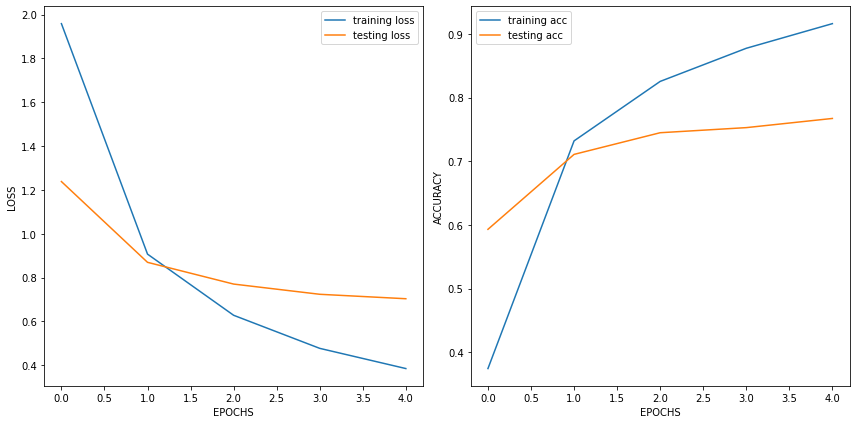


RESNET MODEL ACCURACY: 76.7%.


In [10]:
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_perc.num_classes)

resnet_model.summary()

resnet_model.compile(loss="categorical_crossentropy",
                     optimizer="adam",
                     metrics=["accuracy"])

history_resnet = resnet_model.fit(train_data_10_perc,
                   epochs=5,
                   steps_per_epoch=len(train_data_10_perc),
                   validation_data=test_data_10_perc,
                   validation_steps=len(test_data_10_perc),
                   callbacks=[create_tensorboard_callback("tensor_flow_hub",
                                                          "resnet_v2_50")])

print()
plot_history(history_resnet)
acc_resnet = resnet_model.evaluate(test_data_10_perc, verbose=False)[1]
print(f"\nRESNET MODEL ACCURACY: {100*acc_resnet:.1f}%.")

## Creating and testing EfficientNetB0 TensorFlow Hub Model

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 1280)              4049564   
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________
Saving TensorBoard log files to: tensor_flow_hub/efficient_net/20210816-170826.
Epoch 1/5
24/24 [==============================] - 33s 1s/step - loss: 1.8232 - accuracy: 0.4333 - val_loss: 1.3141 - val_accuracy: 0.7108
Epoch 2/5
24/24 [==============================] - 19s 811ms/step - loss: 1.0637 - accuracy: 0.7640 - val_loss: 0.8831 - val_accuracy: 0.8060
Epoch 3/5
24/24 [==============================] - 19s 807ms/step - loss: 0.7598 - accuracy: 0.8373 - val_loss: 0.7108 - val_accuracy: 0.837

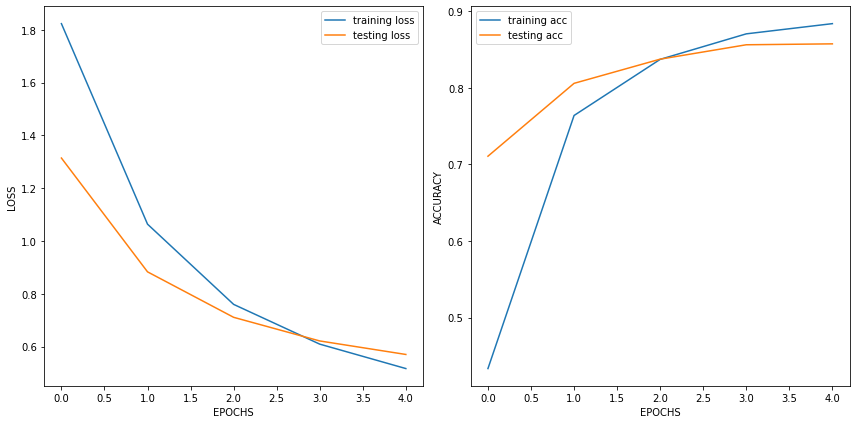


EFICIENT NET MODEL ACCURACY: 85.8%.


In [11]:
effnet_b0_model = create_model(efficientnet_url,
                            num_classes=train_data_10_perc.num_classes)

effnet_b0_model.summary()

effnet_b0_model.compile(loss="categorical_crossentropy",
                     optimizer="adam",
                     metrics=["accuracy"])

history_effnet_b0 = effnet_b0_model.fit(train_data_10_perc,
                   epochs=5,
                   steps_per_epoch=len(train_data_10_perc),
                   validation_data=test_data_10_perc,
                   validation_steps=len(test_data_10_perc),
                   callbacks=[create_tensorboard_callback("tensorflow_hub",
                                                          "efficient_net_b0")])

print()
plot_history(history_effnet_b0)
acc_effnet_b0 = effnet_b0_model.evaluate(test_data_10_perc, verbose=False)[1]
print(f"\nEFICIENT NET MODEL ACCURACY: {100*acc_effnet_b0:.1f}%.")

## Creating a testing EfficientNet B4 Model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 1792)              17673816  
_________________________________________________________________
output_layer (Dense)         (None, 10)                17930     
Total params: 17,691,746
Trainable params: 17,930
Non-trainable params: 17,673,816
_________________________________________________________________
Saving TensorBoard log files to: tensorflow_hub/efficient_net_b4/20210816-183030.
Epoch 1/5
24/24 [==============================] - 66s 998ms/step - loss: 1.7429 - accuracy: 0.4653 - val_loss: 1.1374 - val_accuracy: 0.7428
Epoch 2/5
24/24 [==============================] - 17s 750ms/step - loss: 0.9557 - accuracy: 0.7733 - val_loss: 0.7630 - val_accuracy: 0.8156
Epoch 3/5
24/24 [==============================] - 17s 749ms/step - loss: 0.7030 - accuracy: 0.8267 - val_loss: 0.6419 - val_accuracy: 

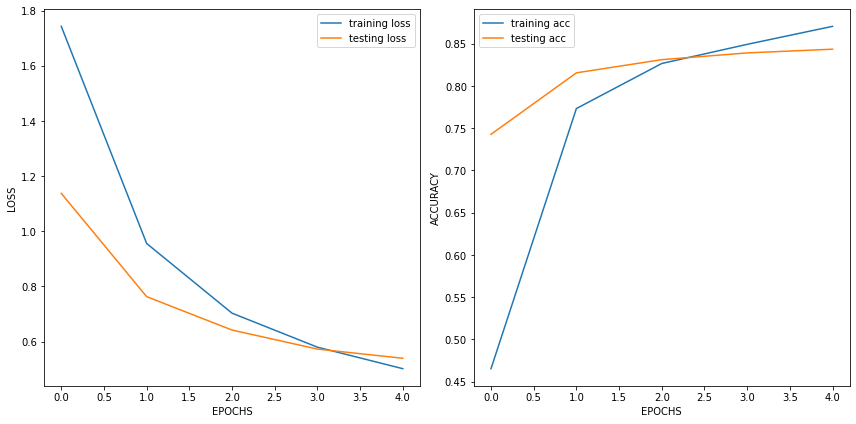


EFICIENT NET MODEL ACCURACY: 84.4%.


In [10]:
effnet_b4_url = "https://tfhub.dev/tensorflow/efficientnet/b4/feature-vector/1"

effnet_b4_model = create_model(effnet_b4_url,
                            num_classes=train_data_10_perc.num_classes)

effnet_b4_model.summary()

effnet_b4_model.compile(loss="categorical_crossentropy",
                     optimizer="adam",
                     metrics=["accuracy"])

history_effnet_b4 = effnet_b4_model.fit(train_data_10_perc,
                   epochs=5,
                   steps_per_epoch=len(train_data_10_perc),
                   validation_data=test_data_10_perc,
                   validation_steps=len(test_data_10_perc),
                   callbacks=[create_tensorboard_callback("tensorflow_hub",
                                                          "efficient_net_b4")])

print()
plot_history(history_effnet_b4)
acc_effnet_b4 = effnet_b4_model.evaluate(test_data_10_perc, verbose=False)[1]
print(f"\nEFICIENT NET MODEL ACCURACY: {100*acc_effnet_b4:.1f}%.")

# Comparing our models results using TensorBoard

In [18]:
# upload tensorboard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ --name "EfficientNetB0, B4 & Resent" \
--description "Comparing three different TF hub feature extraction model architectures using 10% of the training data" \
--one_shot

2021-08-16 17:39:43.798957: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/8Ox9oTOVQyyNjwgNbrgZ5Q/

[2021-08-16T17:39:45] Started scanning logdir.
[2021-08-16T17:39:53] Total uploaded: 90 scalars, 0 tensors, 3 binary objects (13.6 MB)
[2021-08-16T17:39:53] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/8Ox9oTOVQyyNjwgNbrgZ5Q/


In [19]:
!tensorboard dev list

2021-08-16 17:43:57.135092: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
https://tensorboard.dev/experiment/8Ox9oTOVQyyNjwgNbrgZ5Q/
	Name                 EfficientNetB0, B4 & Resent
	Description          Comparing three different TF hub feature extraction model architectures using 10% of the training data
	Id                   8Ox9oTOVQyyNjwgNbrgZ5Q
	Created              2021-08-16 17:39:45 (4 minutes ago)
	Updated              2021-08-16 17:39:53 (4 minutes ago)
	Runs                 6
	Tags                 5
	Scalars              90
	Tensor bytes         0
	Binary object bytes  14255780
https://tensorboard.dev/experiment/taktGegXQ9mhMeRL34OguQ/
	Name                 Simple experiment with MNIST
	Description          Training results from https://colab.sandbox.google.com/github/tensorflow/tensorboard/blob/master/docs/tbdev_getting_started.ipynb
	Id                   taktGegXQ9mhMeRL34OguQ
	Created              20